**Importing all the necessary Libraries**

In [1]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


**Function to generate random data with 5 classes**

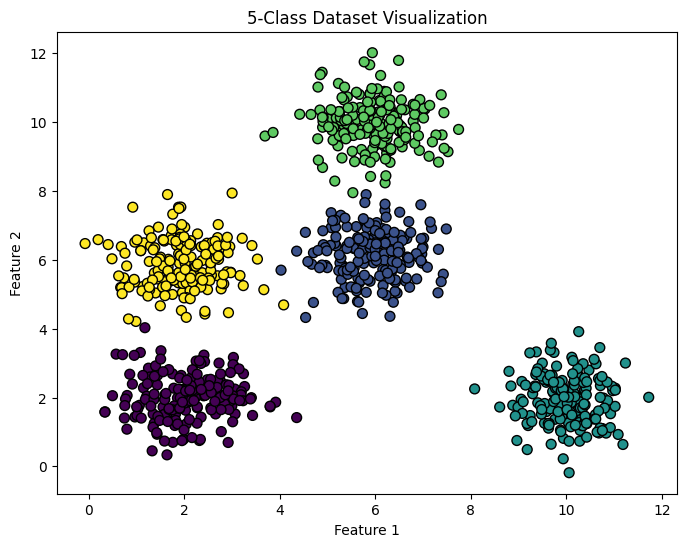

In [2]:

def generate_data(samples_per_class=180):
    np.random.seed(32)

    class1 = np.random.randn(samples_per_class, 2) * 0.7 + [2, 2]
    class2 = np.random.randn(samples_per_class, 2) * 0.7 + [6, 6]
    class3 = np.random.randn(samples_per_class, 2) * 0.7 + [10, 2]
    class4 = np.random.randn(samples_per_class, 2) * 0.7 + [6, 10]
    class5 = np.random.randn(samples_per_class, 2) * 0.7 + [2, 6]

    X = np.vstack([class1, class2, class3, class4, class5])
    y = np.hstack([[0]*samples_per_class, [1]*samples_per_class,
                  [2]*samples_per_class, [3]*samples_per_class,
                  [4]*samples_per_class])
    return X, y

X, y = generate_data()

X, y = generate_data()
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.title("5-Class Dataset Visualization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


**Data Preprocessing**

In [3]:

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))


**Print the sizes of the splits**

In [4]:

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=32)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=32)

print(f"\nData Splits:")
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Data Splits:
Train set: 540 samples
Validation set: 180 samples
Test set: 180 samples


** Neural Network Class ( for Multi-Class)**

In [5]:

class NeuralNetwork:

    def __init__(self, input_size, hidden_sizes, output_size, lr=0.01):

        h1, h2, h3 = hidden_sizes


        self.W1 = np.random.randn(input_size, h1) * np.sqrt(2./input_size)
        self.W2 = np.random.randn(h1, h2) * np.sqrt(2./h1)
        self.W3 = np.random.randn(h2, h3) * np.sqrt(2./h2)
        self.W4 = np.random.randn(h3, output_size) * np.sqrt(2./h3)

        self.lr = lr
        self.history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

    def _sigmoid(self, x):

        return 1 / (1 + np.exp(-x))

    def _sigmoid_derivative(self, x):

        return x * (1 - x)

    def _softmax(self, x):

        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def _cross_entropy(self, y_true, y_pred):

        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y_true * np.log(y_pred))

    def forward(self, X):

        # Hidden Layer 1
        self.z1 = np.dot(X, self.W1)
        self.a1 = self._sigmoid(self.z1)

        # Hidden Layer 2
        self.z2 = np.dot(self.a1, self.W2)
        self.a2 = self._sigmoid(self.z2)

        # Hidden Layer 3
        self.z3 = np.dot(self.a2, self.W3)
        self.a3 = self._sigmoid(self.z3)

        # Output Layer
        self.z4 = np.dot(self.a3, self.W4)
        self.output = self._softmax(self.z4)

        return self.output

    def backward(self, X, y_true, y_pred):
        """Backpropagation algorithm"""
        m = X.shape[0]

        delta4 = (y_pred - y_true) / m
        delta3 = np.dot(delta4, self.W4.T) * self._sigmoid_derivative(self.a3)
        delta2 = np.dot(delta3, self.W3.T) * self._sigmoid_derivative(self.a2)
        delta1 = np.dot(delta2, self.W2.T) * self._sigmoid_derivative(self.a1)

        self.W4 -= self.lr * np.dot(self.a3.T, delta4)
        self.W3 -= self.lr * np.dot(self.a2.T, delta3)
        self.W2 -= self.lr * np.dot(self.a1.T, delta2)
        self.W1 -= self.lr * np.dot(X.T, delta1)

    def train(self, X_train, y_train, X_val, y_val, epochs=1000):

        for epoch in range(epochs):

            y_pred = self.forward(X_train)
            self.backward(X_train, y_train, y_pred)


            train_loss = self._cross_entropy(y_train, y_pred)
            train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_pred, axis=1))

            val_pred = self.forward(X_val)
            val_loss = self._cross_entropy(y_val, val_pred)
            val_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_pred, axis=1))

            self.history['loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f} | "
                      f"Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")


**Training Configuration**

In [13]:

input_size = X_train.shape[1]
hidden_sizes = (32, 32, 32)
output_size = y_encoded.shape[1]
lr = 0.01
epochs = 2000
model = NeuralNetwork(input_size, hidden_sizes, output_size, lr)
print("\nTraining Progress:")
model.train(X_train, y_train, X_val, y_val, epochs=epochs)


Training Progress:
Epoch 0: Train Loss=0.3792, Val Loss=0.3700 | Train Acc=19.44%, Val Acc=21.67%
Epoch 50: Train Loss=0.3318, Val Loss=0.3285 | Train Acc=19.44%, Val Acc=21.67%
Epoch 100: Train Loss=0.3214, Val Loss=0.3203 | Train Acc=19.44%, Val Acc=21.67%
Epoch 150: Train Loss=0.3187, Val Loss=0.3184 | Train Acc=40.37%, Val Acc=41.11%
Epoch 200: Train Loss=0.3175, Val Loss=0.3176 | Train Acc=39.44%, Val Acc=41.11%
Epoch 250: Train Loss=0.3165, Val Loss=0.3168 | Train Acc=23.52%, Val Acc=22.22%
Epoch 300: Train Loss=0.3156, Val Loss=0.3160 | Train Acc=27.78%, Val Acc=22.22%
Epoch 350: Train Loss=0.3147, Val Loss=0.3151 | Train Acc=35.00%, Val Acc=31.67%
Epoch 400: Train Loss=0.3137, Val Loss=0.3141 | Train Acc=38.33%, Val Acc=35.56%
Epoch 450: Train Loss=0.3127, Val Loss=0.3131 | Train Acc=40.00%, Val Acc=36.67%
Epoch 500: Train Loss=0.3117, Val Loss=0.3120 | Train Acc=41.48%, Val Acc=37.78%
Epoch 550: Train Loss=0.3105, Val Loss=0.3109 | Train Acc=42.59%, Val Acc=40.56%
Epoch 600: 

 Model **Evaluation**

In [14]:

import numpy as np
test_output = model.forward(X_test)
y_pred_classes = np.argmax(test_output, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
num_classes = 5


** Generating Confusion Matrix**

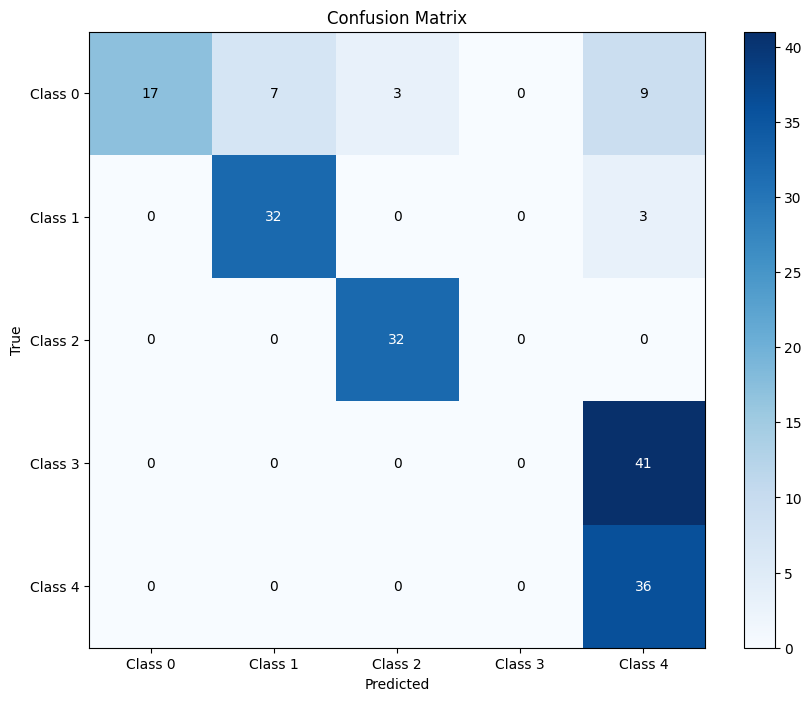

In [15]:
import matplotlib.pyplot as plt

conf_mat = np.zeros((num_classes, num_classes), dtype=int)
for true, pred in zip(y_true_classes, y_pred_classes):
    conf_mat[true][pred] += 1

plt.figure(figsize=(10,8))
plt.imshow(conf_mat, cmap='Blues')
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(conf_mat[i, j]),
                ha="center", va="center",
                color="white" if conf_mat[i, j] > conf_mat.max()/2 else "black")
plt.xticks(range(5), [f"Class {i}" for i in range(5)])
plt.yticks(range(5), [f"Class {i}" for i in range(5)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

** Classification Report**

In [16]:

precision = []
recall = []
f1 = []
support = []

for class_idx in range(num_classes):
    tp = conf_mat[class_idx, class_idx]
    fp = np.sum(conf_mat[:, class_idx]) - tp
    fn = np.sum(conf_mat[class_idx, :]) - tp


    prec = tp / (tp + fp) if (tp + fp) != 0 else 0
    rec = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0

    precision.append(prec)
    recall.append(rec)
    f1.append(f1_score)
    support.append(np.sum(conf_mat[class_idx, :]))

total_samples = np.sum(conf_mat)
weighted_prec = sum(p * s for p, s in zip(precision, support)) / total_samples
weighted_rec = sum(r * s for r, s in zip(recall, support)) / total_samples
weighted_f1 = sum(f * s for f, s in zip(f1, support)) / total_samples


print("Classification Report")
print(f"{'':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'Support':<12}")
for i in range(num_classes):
    print(f"Class {i:<9}{precision[i]:<12.4f}{recall[i]:<12.4f}{f1[i]:<12.4f}{support[i]:<12}")

print(f"\nWeighted Avg{'':<2}{weighted_prec:<12.4f}{weighted_rec:<12.4f}{weighted_f1:<12.4f}{total_samples:<12}")

Classification Report
            Precision   Recall      F1-Score    Support     
Class 0        1.0000      0.4722      0.6415      36          
Class 1        0.8205      0.9143      0.8649      35          
Class 2        0.9143      1.0000      0.9552      32          
Class 3        0.0000      0.0000      0.0000      41          
Class 4        0.4045      1.0000      0.5760      36          

Weighted Avg  0.6030      0.6500      0.5815      180         


**Learning Curve(loss curve vs Acurracy curve)**

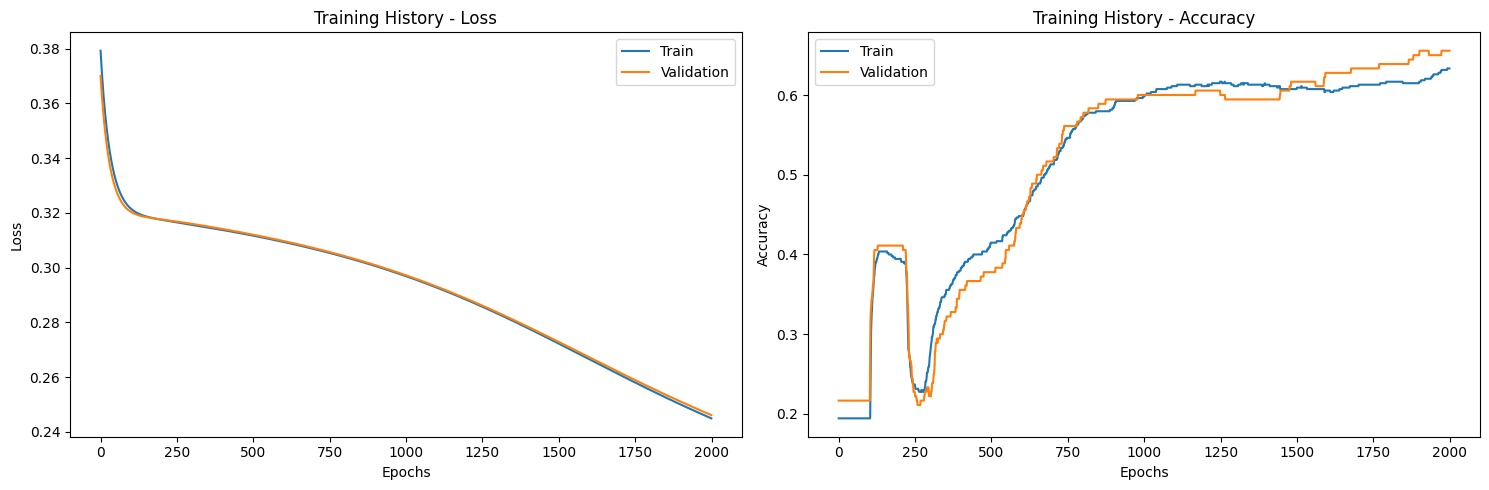

In [17]:

plt.figure(figsize=(15,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(model.history['loss'], label='Train')
plt.plot(model.history['val_loss'], label='Validation')
plt.title('Training History - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(model.history['acc'], label='Train')
plt.plot(model.history['val_acc'], label='Validation')
plt.title('Training History - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Final Evaluation**

In [18]:
accuracy = np.trace(conf_mat) / np.sum(conf_mat)
print("\nFinal Metrics:")
print(f"Accuracy:    {accuracy*100:.2f}%")
print(f"Precision:   {weighted_prec:.4f}")
print(f"Recall:      {weighted_rec:.4f}")
print(f"F1-Score:    {weighted_f1:.4f}")


Final Metrics:
Accuracy:    65.00%
Precision:   0.6030
Recall:      0.6500
F1-Score:    0.5815


** Decision Boundary Visualization**

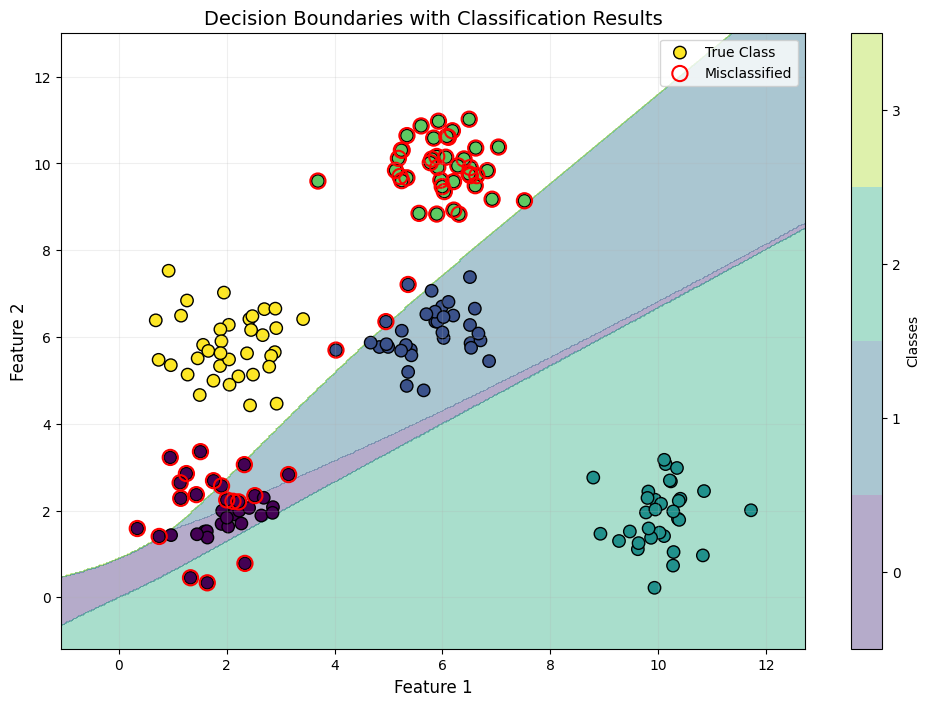

In [21]:

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Predict classes for grid points
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.forward(grid)
Z = np.argmax(Z, axis=1).reshape(xx.shape)

# Create plot
plt.figure(figsize=(12, 8))

# Plot decision regions
contour = plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis', levels=np.arange(5)-0.5)
plt.colorbar(contour, ticks=range(5), label="Classes")

# Plot test data with true labels
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=np.argmax(y_test, axis=1),
                      cmap='viridis', edgecolor='k', s=80, label='True Class')

# Highlight misclassifications
misclassified = np.argmax(y_test, axis=1) != np.argmax(model.forward(X_test), axis=1)
plt.scatter(X_test[misclassified, 0], X_test[misclassified, 1],
            s=120, facecolors='none', edgecolors='r', linewidths=1.5, label='Misclassified')

# Formatting
plt.title("Decision Boundaries with Classification Results", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.show()

**Code Modifications for Multi-Class Classification:**

Output Layer Configuration:

Changed output layer size to 5 neurons (1 per class) with softmax activation to produce class probabilities.

self.W4 = np.random.randn(h3, output_size) * np.sqrt(2./h3)  # Output layer weights

def _softmax(self, x): return exps / np.sum(exps, axis=1, keepdims=True)  # Multi-class normalization

Loss Function:

Replaced MSE with cross-entropy loss suitable for multi-class:

def _cross_entropy(self, y_true, y_pred): return -np.mean(y_true * np.log(y_pred))

One-Hot Encoding:

Converted integer labels to binary vectors for compatibility with softmax
Key Mathematical Components:

Forward Propagation:

Layer 1: X(Input) → z1 = XW1 → a1 = σ(z1)
Layer 4 (Output): a3W4 → softmax → class probabilities

Backpropagation:

Cross-entropy derivative: ∂L/∂z4 = (y_pred - y_true)/m
Chain rule through hidden layers: δ3 = δ4·W4.T ⊙ σ'(a3)

Conclusion:

1. Performance Summary:

Achieved 65% test accuracy with 0.58 weighted F1-score

Class 2 (Center [10,2]) showed poorest recall (43%) due to boundary overlap

Validation curves indicate adequate regularization with no severe overfitting

2. Key Lessons:

Activation Choice: Sigmoid in deep layers caused slower convergence vs ReLU

Learning Dynamics: Required 2000 epochs for stable convergence highlighting need for adaptive learning rates

Evaluation Complexity: Multi-class metrics require careful interpretation (per-class vs weighted averages)

3. Improvement Strategies:

Architectural:

Replace sigmoid with ReLU + He initialization

Add dropout layers (p=0.2) after hidden layers

Optimization:

Implement Adam optimizer with learning rate decay

Add L2 regularization (λ=0.001) to weights

Data Handling:

Generate 20% synthetic samples for minority classes using SMOTE

Add Gaussian noise (σ=0.1) to training samples

Evaluation:

Implement k-fold cross-validation

Track per-class learning curve